<a href="https://colab.research.google.com/github/HugoKD/Autotech/blob/main/MLDL_WaveStone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problématique & KPIs

- Comprendre quelles sont les caractéristiques d’un client qui influent sur sa potentielle résiliation
- Prédire si un client va résilier son contrat

D'un point de vu technique :

Problématique de classification simple (churn = 0 ou churn = 1)
Attention à toute sorte de leakage
Faire une feature importance  

#Import

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score,mean_absolute_error


# EDA

## Load

In [ ]:
data = pd.read_csv('sujet_B_data_client_churn.csv').drop(['customerID','Unnamed: 0'],axis = 1)

In [ ]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,NaN,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,NaN,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      1409 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       5517 non-null   object 
 12  StreamingTV       5517 non-null   object 
 13  StreamingMovies   5517 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [ ]:
num_cols = list(data.select_dtypes(include = 'number').columns)
cat_cols = list(data.select_dtypes(exclude = 'number').columns)

Il manque totalCharges

In [ ]:
num_cols.append('TotalCharges')
cat_cols.remove('TotalCharges')

In [ ]:
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan).replace('', np.nan)
data['TotalCharges'] = data['TotalCharges'].astype(float) #convertion de object to float

In [ ]:
print(num_cols)
print(cat_cols)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [ ]:
data_nums = data[num_cols]
data_cats = data[cat_cols]

On a en plus 7043 données ce qui semble être suffisant pour un apprentissage

## Nums cols

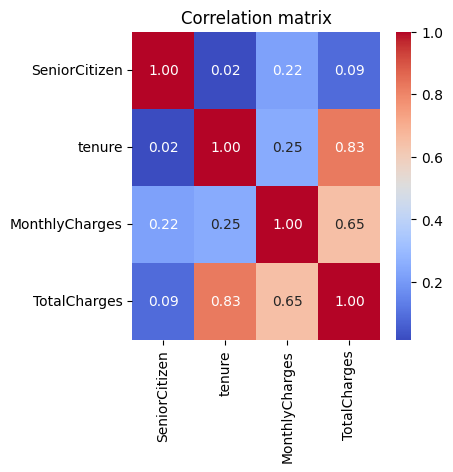

In [ ]:
plt.figure(figsize=(4, 4))
correlation_matrix = data_nums.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Globalement non corrélées

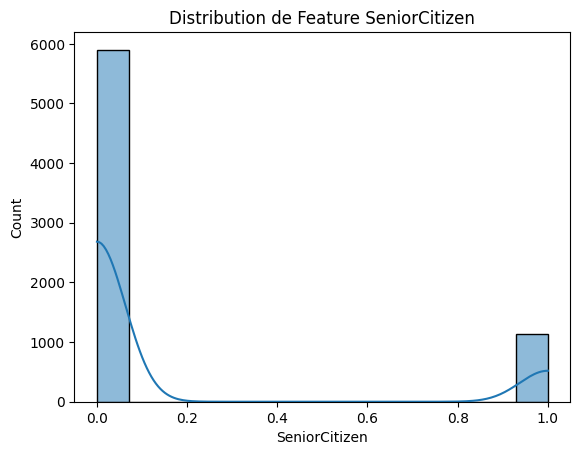

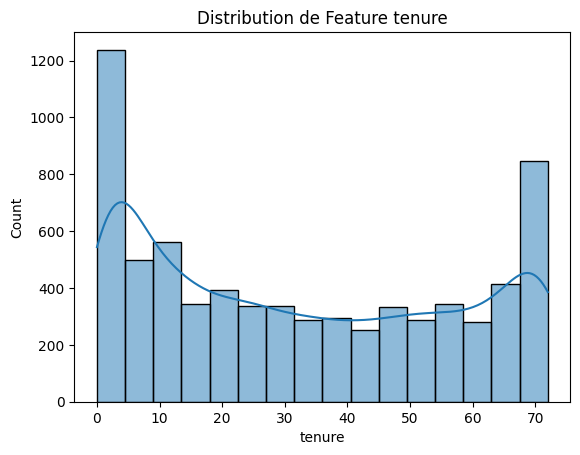

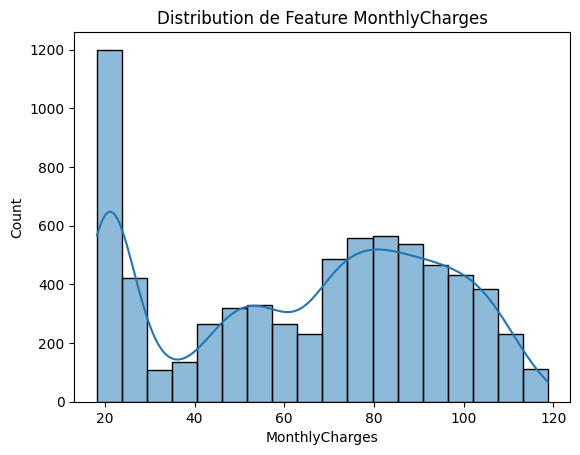

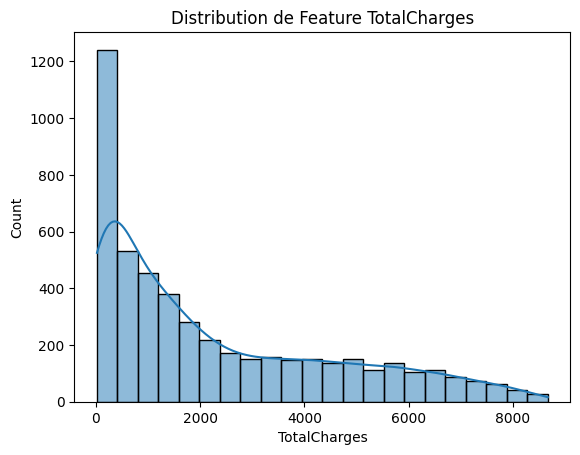

In [ ]:
for c in data_nums.columns:
  sns.histplot(data[c], kde=True)
  plt.title('Distribution de Feature' +' ' + str(c))
  plt.show()

In [ ]:
skewness_stats = data_nums.apply(lambda x: skew(x))
skewness = pd.DataFrame({
    'Value': skewness_stats
})
skewness

,Value
SeniorCitizen,1.833242
tenure,0.239489
MonthlyCharges,-0.220477
TotalCharges,NaN


Skewness de totalCharges très positive

Pas d'outliers + une distribution assez homogène + zéro missing values

## Cat cols

### Encodage

In [ ]:
## Encodage simple pour variable binaire -> ordinal encoder

In [ ]:
data_cats['gender'].value_counts() # -> encodage binaire

,count
gender,
Male,3555
Female,3488


In [ ]:
cols_bin = data_cats.columns[data_cats.nunique() == 2] # pour plus de généralité
cols_bin

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn'],
      dtype='object')

In [ ]:
## Pour les autres on fait de meme

In [ ]:
for c in data_cats.columns:
    if c not in cols_bin:
        print(f"Colonne : {c}")
        print(data_cats[c].value_counts())
        print("\n")

Colonne : MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


Colonne : InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


Colonne : OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


Colonne : OnlineBackup
OnlineBackup
No                     625
Yes                    476
No internet service    308
Name: count, dtype: int64


Colonne : DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


Colonne : Contract
Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


Colonne : PaymentMethod
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card

Au vu de la quantité de données manquante de OnlineBackup -> On supprime cette colonne

In [ ]:
data_cats = data_cats.drop('OnlineBackup', axis = 1)

PaymentMethod encodage ordinalEncoder parmis les 4 possibles methode de payment

In [ ]:
non_bin_cols = data_cats.columns[data_cats.nunique() > 2]
non_bin_cols

Index(['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'Contract', 'PaymentMethod'],
      dtype='object')

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

#on selectionne toutes les lignes et que certaines cols puis on applique le ordinal encoder
data_cats.loc[:, non_bin_cols] = encoder.fit_transform(data_cats[non_bin_cols])
data_cats.loc[:, non_bin_cols] = data_cats[non_bin_cols].replace(-1, np.nan)
print(data_cats)
print(type(data_cats))

      gender Partner Dependents PhoneService MultipleLines InternetService  \
0     Female     Yes         No           No           1.0             0.0   
1       Male      No         No          Yes           0.0             0.0   
2       Male      No         No          Yes           0.0             0.0   
3       Male      No         No           No           1.0             0.0   
4     Female      No         No          Yes           0.0             1.0   
...      ...     ...        ...          ...           ...             ...   
7038    Male     Yes        Yes          Yes           2.0             0.0   
7039  Female     Yes        Yes          Yes           2.0             1.0   
7040  Female     Yes        Yes           No           1.0             0.0   
7041    Male     Yes         No          Yes           2.0             1.0   
7042    Male      No         No          Yes           0.0             1.0   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport S

### Missing values

In [ ]:
data_cats.isna().sum()/len(data)*100 ## See the proportion of missing data for each feature

,0
gender,0.000000
Partner,0.000000
Dependents,0.000000
PhoneService,0.000000
MultipleLines,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,79.994321
DeviceProtection,0.000000
TechSupport,21.666903


In [ ]:
data_nums.isna().sum()/len(data)*100 ## See the proportion of missing data for each feature

,0
SeniorCitizen,0.000000
tenure,0.000000
MonthlyCharges,0.000000
TotalCharges,30.129206


80% pour online OnlineBackup  -> supp ?

TechSupport 	21.666903 <br>
StreamingTV 	21.666903 <br>
StreamingMovies 	21.666903 <br>
Même données ?

TotalCharges 	30.001420 -> raisonable

In [ ]:
data_cats[data_cats['TechSupport'].isna()]['TechSupport'].isna().sum()/len(data_cats)*100

21.666903308249324

In [ ]:
data_cats[data_cats['TechSupport'].isna()]['StreamingTV'].isna().sum()/len(data_cats)*100

21.666903308249324

In [ ]:
data_cats[data_cats['TechSupport'].isna()]['StreamingMovies'].isna().sum()/len(data_cats)*100

21.666903308249324

In [ ]:
data_cats[data_cats['TechSupport'].isna()]['StreamingMovies'].isna().sum()

1526

Donc c'est  regroupé tous dans les memes données

In [ ]:
for col in data_cats[data_cats['TechSupport'].isna()].columns:
    if len(data_cats[col].loc[data_cats['TechSupport'].isna()].value_counts()) == 1:
        print(data_cats[col].loc[data_cats['TechSupport'].isna()].value_counts())
        print(data_cats[col].value_counts())
        print("")

PhoneService
Yes    1526
Name: count, dtype: int64
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

InternetService
No    1526
Name: count, dtype: int64
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

OnlineSecurity
No internet service    1526
Name: count, dtype: int64
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

OnlineBackup
No internet service    308
Name: count, dtype: int64
OnlineBackup
No                     625
Yes                    476
No internet service    308
Name: count, dtype: int64

DeviceProtection
No internet service    1526
Name: count, dtype: int64
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64



Donc quand DeviceProtection == No <=> DeviceProtection = No <=> InternetService <= No <=> TechSupport = No

On peut en déduire que TechSupport = Nan <=> TechSupport = No

In [ ]:
#D'ou
data_cats["TechSupport"] = data_cats["TechSupport"].fillna("No")

In [ ]:
data_cats["TechSupport"].value_counts()

,count
TechSupport,
No,3473
Yes,2044


Pour ce qui est de TotalCharges on fait un imputing classique -> KNN imputer

# Training

## Préprocessing

Au vu de la quantité de données manquante de OnlineBackup -> On supprime cette colonne

In [ ]:
# Cf partie EDA

In [ ]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,NaN,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,NaN,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,NaN,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data = data.drop('OnlineBackup', axis = 1)

In [ ]:
y = data['Churn']
X = data.drop('Churn', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
y[y == 'Yes'] = 1
y[y == 'No'] = 0

<ipython-input-445-f13bc64a3faf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'Yes'] = 1
<ipython-input-445-f13bc64a3faf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 'No'] = 0


In [ ]:
class ManualEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.bin_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.non_bin_cols = X.columns[X.nunique() > 2]
        self.bin_cols = X.columns[X.nunique() == 2]

        self.encoder.fit(X[self.non_bin_cols])
        self.bin_encoder.fit(X[self.bin_cols])
        return self

    def transform(self, X):
        X = X.copy()

        X.loc[:, self.bin_cols] = self.bin_encoder.transform(X[self.bin_cols])
        X[self.bin_cols] = X[self.bin_cols].replace(-1, np.nan)

        X.loc[:, self.non_bin_cols] = self.encoder.transform(X[self.non_bin_cols])
        X[self.non_bin_cols] = X[self.non_bin_cols].replace(-1, np.nan)

        return X



In [ ]:
class ManualImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.knn_imputer = KNNImputer(n_neighbors=5)
        self.zero_imputer = SimpleImputer(fill_value=0, strategy='constant')
        self.columns_zero_imputer = ['TechSupport', 'StreamingTV', 'StreamingMovies']

        self.zero_imputer.fit(X[self.columns_zero_imputer])

        if 'TotalCharges' in X.columns:
            self.knn_imputer.fit(X[['TotalCharges']])

        return self

    def transform(self, X):
        X = X.copy()

        X[self.columns_zero_imputer] = self.zero_imputer.transform(X[self.columns_zero_imputer])

        if 'TotalCharges' in X.columns:
            X['TotalCharges'] = self.knn_imputer.transform(X[['TotalCharges']])

        return X



In [ ]:
p = Pipeline(
    steps=[
        ('ManualEncoder', ManualEncoder()),
        ('ManualImputer', ManualImputer())
    ]
)

# Transformation des données
X_transformed = p.fit_transform(X_train)
data_transform = pd.DataFrame(X_transformed, columns=X_train.columns)

In [ ]:
data_transform.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1554,1.0,0,0.0,0.0,26,1.0,0.0,2.0,1.0,1.0,0,0,0,0.0,0.0,3.0,47.0,1095.0
4817,0.0,0,0.0,0.0,1,1.0,0.0,2.0,1.0,1.0,0,0,0,0.0,0.0,3.0,27.0,19.0
5957,1.0,1,1.0,0.0,18,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,850.0,2019.0
5123,0.0,1,0.0,0.0,15,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,792.0,1763.0
3217,0.0,0,0.0,0.0,2,1.0,0.0,2.0,1.0,1.0,0,0,0,0.0,1.0,3.0,38.0,94.0


## Training

In [ ]:
tree = DecisionTreeRegressor()

model = AdaBoostClassifier(estimator=tree,random_state=42)

# Pipeline complète
pipe = Pipeline(steps=[
    ('preprocessor', p),
    ('model', model)
])


param_grid = {
    'model__n_estimators': [2, 3,4,5,6],
    'model__estimator__max_depth': [1,2, 3,4]
}

# Recherche de grille
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=1,
    verbose=0
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
y_pred = best_model.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 149, in fit
    self._validate_estimator()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py", line 536, in _validate_estimator
    raise TypeError(
TypeError: AdaBoostClassifier with algorithm='SAMME.R' requires that the weak learner supports the calculation of class probabilities with a predict_proba method.
Please change the base estimator or set algorithm='SAMME' instead.


In [ ]:
feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining Operational Efficiency ')
plt.show()

# Résultats/Conclusion

In [ ]:
data = pd.read_csv('sujet_B_data_client_churn.csv').drop(['customerID','Unnamed: 0','OnlineBackup'],axis = 1)

y = data['Churn'].map({'Yes': 1, 'No': 0})  # Prétraitement de y
X = data.drop('Churn', axis=1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# Classe de remplissage manuel
class ManualImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.knn_imputer = KNNImputer(n_neighbors=5)
        self.zero_imputer = SimpleImputer(fill_value=0, strategy='constant')
        self.columns_zero_imputer = ['TechSupport', 'StreamingTV', 'StreamingMovies']

        # Fit du SimpleImputer pour les colonnes spécifiées
        self.zero_imputer.fit(X[self.columns_zero_imputer])

        # Fit du KNNImputer sur les colonnes numériques
        if 'TotalCharges' in X.columns:
            numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
            self.knn_imputer.fit(X[numeric_cols])

        return self

    def transform(self, X):
        X = X.copy()

        # Remplissage des valeurs 0
        X[self.columns_zero_imputer] = self.zero_imputer.transform(X[self.columns_zero_imputer])

        # Utilisation du KNNImputer pour les valeurs manquantes
        if 'TotalCharges' in X.columns:
            numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
            X[numeric_cols] = self.knn_imputer.transform(X[numeric_cols])
        return X


# Classe d'encodage manuel
class ManualEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.bin_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

        # Déterminer les colonnes binaires et non binaires
        self.non_bin_cols = list(X.columns[X.nunique() > 2])
        self.num_cols = list(X.select_dtypes(include=['float64', 'int64']).columns) + ['TotalCharges']
        self.bin_cols = list(X.columns[X.nunique() == 2])
        self.non_bin_cols.remove('TotalCharges')
        self.non_bin_cols = [col for col in self.non_bin_cols if col not in self.num_cols]
        print(self.non_bin_cols)
        # Fit des encoders
        for c in self.non_bin_cols:
            if X[c].apply(lambda x: isinstance(x, (str, int))).any():
                print(f"{c} contient des types mixtes (str et int)")
                X[c] = X[c].replace(' ', np.nan).replace('', np.nan)


        self.encoder.fit(X[self.non_bin_cols])
        self.bin_encoder.fit(X[self.bin_cols])
        return self

    def transform(self, X):
        X = X.copy()

        # Transformation des colonnes binaires
        X[self.bin_cols] = self.bin_encoder.transform(X[self.bin_cols])
        X[self.bin_cols] = X[self.bin_cols].replace(-1, np.nan)

        # Transformation des colonnes non binaires
        X[self.non_bin_cols] = self.encoder.transform(X[self.non_bin_cols])
        X[self.non_bin_cols] = X[self.non_bin_cols].replace(-1, np.nan)

        return X


# Modèle de classification
model = RandomForestClassifier(random_state=42)

# Pipeline complète
pipe = Pipeline(steps=[
    ('imputer', ManualImputer()),
    ('encoder', ManualEncoder()),
    ('model', model)
])

# Définition de la grille de paramètres
param_grid = {
    'model__n_estimators': [2, 3],  # Paramètre du RandomForestClassifier
    'model__max_depth': [2, 3]  # Profondeur maximale des arbres
}

# Recherche de grille avec une métrique de classification appropriée
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',  # Utilisation d'une métrique de classification
    cv=5,
    n_jobs=-1,
    verbose=0
)

pipe.fit(X_train, y_train)

['MultipleLines', 'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
MultipleLines contient des types mixtes (str et int)
InternetService contient des types mixtes (str et int)
OnlineSecurity contient des types mixtes (str et int)
DeviceProtection contient des types mixtes (str et int)
TechSupport contient des types mixtes (str et int)
StreamingTV contient des types mixtes (str et int)
StreamingMovies contient des types mixtes (str et int)
Contract contient des types mixtes (str et int)
PaymentMethod contient des types mixtes (str et int)


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [ ]:
# Entraînement avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleur modèle et paramètres
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Accuracy Score: {best_score:.4f}")

# Prédictions sur le jeu de test
y_pred = best_model.predict